EE 224 PSet 2
Kapil Dheeriya

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from mpl_toolkits.axes_grid1 import AxesGrid

Problem 2f

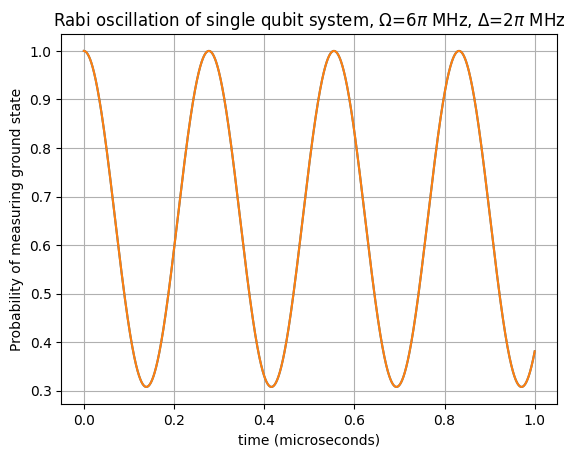

In [31]:
pauli = np.array((((0, 1), (1, 0)), ((0, -1j), (1j, 0)), ((1, 0), (0, -1))))
g = np.array([1,0])
e = np.array([0,1])

def psi(t, omega, delta):
    Heff = -(0.5*omega*pauli[2])+(0.5*delta*pauli[0])
    #Diagonalize Hamiltonian - get eigenvectors and eigenvalues
    evals = np.linalg.eigh(Heff)[0]
    evecs = np.linalg.eigh(Heff)[1]
    #To write the ground state (1,0) as a linear combo of the eigenstates: get coefficients c1 and c2
    #by solving the system (c1 c2) = [v1 v2]^-1 (1 0)
    c = np.linalg.inv(evecs)*g
    #Add in exponential phase factors to write full psi(t) in terms of the eigenstates
    return (c[0]*evecs[0]*np.exp(1j*evals[0]*t) + c[1]*evecs[1]*np.exp(1j*evals[1]*t))

t = np.linspace(0, 1, 10001)
pg = []
for i in range(0, len(t)):
    pg.append(np.abs(np.inner(psi(t[i], 2*2*np.pi, 2*np.pi*3),g))**2)

fig, ax  = plt.subplots()
ax.plot(t, pg)
ax.set(xlabel='time (microseconds)', ylabel='Probability of measuring ground state',
       title='Rabi oscillation of single qubit system, $\Omega$=6$\pi$ MHz, $\Delta$=2$\pi$ MHz')
ax.grid()
plt.plot(t, pg)


This plot is consistent with analytical prediction. Note the period is consistent with a predicted
period of T = 2pi/Omega_eff = 0.316 microseconds. Furthermore, for a detuning of 1/3 omega we'd expect
the probability to nearly reach zero every period, which it does in the plot.

Part c

Problem 3

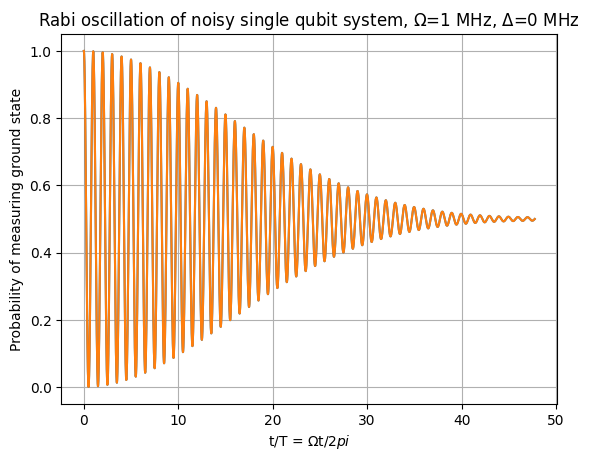

In [34]:
#Numerically generate probability of ground state as a function of time with gaussian omega.
def pgnoisy(omega, f ,M, timerange, numsteps):
    rng = np.random.default_rng() 
    t = np.linspace(0, timerange, numsteps)
    omegam = rng.normal(omega, f*omega, M)
    pgn = []
    for i in range(0, len(t)):
        #compute probability for a given time t
        pgn.append((1 / M)*sum(np.cos(((omegam / 2)*t[i] ))**2))
    return t, pgn

pgnoisy1 = pgnoisy(1, 0.01, 1000, 300, 10001)
fig, ax  = plt.subplots()
ax.plot((pgnoisy1[0] / (2*np.pi)), pgnoisy1[1])
ax.set(xlabel='t/T = $\Omega$t/2$pi$', ylabel='Probability of measuring ground state',
       title='Rabi oscillation of noisy single qubit system, $\Omega$=1 MHz, $\Delta$=0 MHz')
ax.grid()
plt.plot((pgnoisy1[0] / (2*np.pi)), pgnoisy1[1])


Numerically find the number of rabi oscillation cycles up to the 1/e decay time.

In [4]:
def fit(t, ylevel, angfreq, stddev):
    pg = (1-ylevel) + ylevel*np.cos(angfreq*t)*np.exp(-((stddev*t)**2)/2)
    return pg

def extractN(omega, f, M): 
    timerange = 500
    numsteps =100001
    params, _ = scipy.optimize.curve_fit(fit, np.linspace(0, timerange, numsteps), 
                                         pgnoisy(omega, f, M, timerange, numsteps))
    #print(params)
    ylevel, angfreq, stddev = params
    #compute 1/e decay time based on fitted standard deviation of gaussian.
    Te = np.sqrt(2) / stddev
    #Divide decay time by rabi frequency to get numerical value of N 1/e
    Ne_numerical = (np.abs(angfreq)*np.abs(Te))/(2*np.pi)
    #Compute predicted N 1/e value
    Ne_predicted = np.sqrt(2)/(2*np.pi*f)
    return Ne_numerical, Ne_predicted

omegalist = [1, 10, 50, 100]
for i in omegalist:
    n = extractN(i, 0.01, 1000)
    print(f"$\Omega$ = {i} \n Numerical N 1/e = {n[0]}\nPredicted N 1/e = {n[1]}")

$\Omega$ = 1 
 Numerical N 1/e = 22.659282010313788
Predicted N 1/e = 22.507907903927652
$\Omega$ = 10 
 Numerical N 1/e = 22.522008281090123
Predicted N 1/e = 22.507907903927652
$\Omega$ = 50 
 Numerical N 1/e = 24.04466075515943
Predicted N 1/e = 22.507907903927652
$\Omega$ = 100 
 Numerical N 1/e = 23.846075917667026
Predicted N 1/e = 22.507907903927652


Clearly the numerical and predicted values for N 1/e are consistent with the predicted values of N 1/e according to the formula in 3c.

Part E

In [112]:
def pgdetuned(omega, f ,M, timerange, numsteps, delta, deltastd):
    rng = np.random.default_rng(11)
    rng2 = np.random.default_rng(123) 
    t = np.linspace(0, timerange, numsteps)
    omegam = rng.normal(omega, f*omega, M)
    deltam = rng2.normal(delta, deltastd, M)
    pgn = []
    
    #for i in range(0,len(t)):
    #    pgn_at_t = 0
    #    for j in range(0,M):
    #        psirandom = psi(t[i], omegam[j], deltam[j])
    #        pgn_at_t+=(np.abs(np.inner(psirandom,g))**2)
    #    pgn.append((1/M)*pgn_at_t)
    
    omegaeff = np.sqrt(np.square(omegam) + np.square(deltam))
    #compute probability for a given time t
    for i in range(0, len(t)):
        pgn.append((1 / M)*sum(1-(np.square((omegam/omegaeff)))*(np.square(np.sin(0.5*omegaeff*t[i])))))
        #pgn.append((1 / M)*sum(np.abs(np.cos(.5*omegaeff*t[i])+(1j*deltam/(omegaeff))*np.sin(.5*omegaeff*t[i]))**2))
    return t, pgn

def fitdetuned(t, ylevel, angfreq, T1e, C):
    pg = (1-ylevel) + ylevel*np.cos(angfreq*t)*np.exp(-((t/T1e)**C))
    return pg

def extractNdetuned(omega, f, M, delta, deltastd): 
    #timerange = (2*np.pi*omega)*(7 / (2*np.pi))
    timerange = 7
    numsteps =10001
    detuneddata = pgdetuned(omega, f, M, timerange, numsteps, delta, deltastd)
    params, _ = scipy.optimize.curve_fit(fitdetuned, (2*np.pi*omega)*(detuneddata[0] / (2*np.pi)), 
                                         detuneddata[1])
    #print(params)
    ylevel, angfreq, T1e, C = params
    #Divide decay time by rabi frequency to get numerical value of N 1/e
    Ne_numerical = (np.abs(angfreq)*np.abs(T1e))
    #Compute predicted N 1/e value
    Ne_predicted = np.sqrt(2)/(2*np.pi*f)
    return Ne_numerical, Ne_predicted


Omega = 0.5 * 2pi MHz
Numerical N 1/e : (2.1502382214937406, 22.507907903927652)


C:\Users\kapil\AppData\Local\Temp\ipykernel_29448\2558986337.py:24: RuntimeWarning: divide by zero encountered in power
  pg = (1-ylevel) + ylevel*np.cos(angfreq*t)*np.exp(-((t/T1e)**C))


Omega = 2.875 * 2pi MHz
Numerical N 1/e : (7.032373657596203, 22.507907903927652)
Omega = 5.25 * 2pi MHz
Numerical N 1/e : (8.960678286354188, 22.507907903927652)
Omega = 7.625 * 2pi MHz
Numerical N 1/e : (11.103452745119322, 22.507907903927652)
Omega = 10.0 * 2pi MHz
Numerical N 1/e : (13.775867062197946, 22.507907903927652)


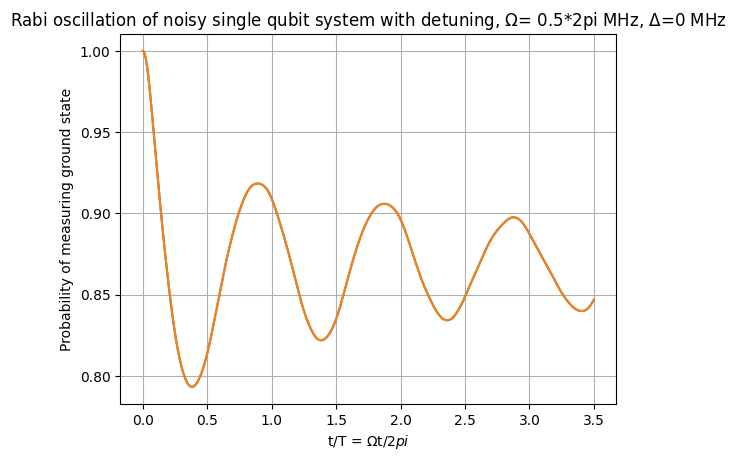

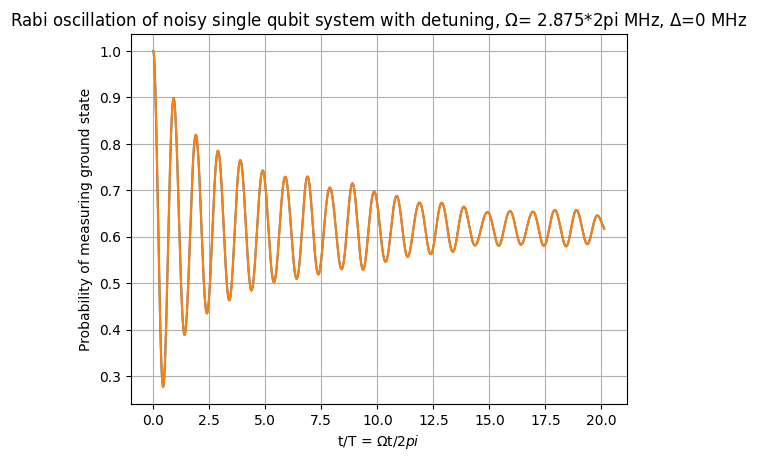

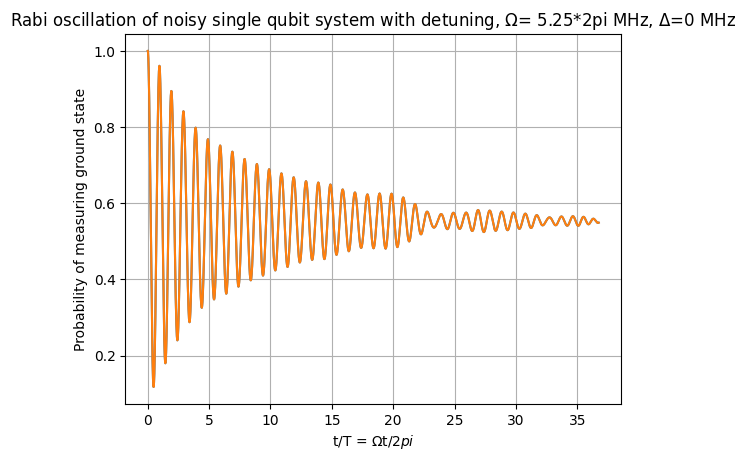

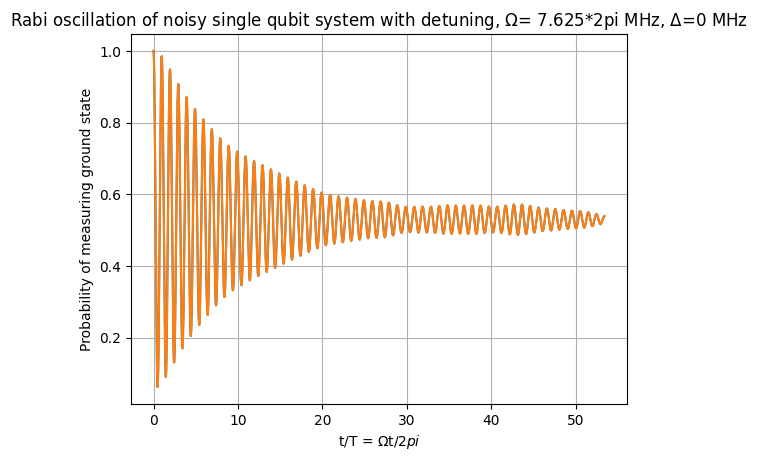

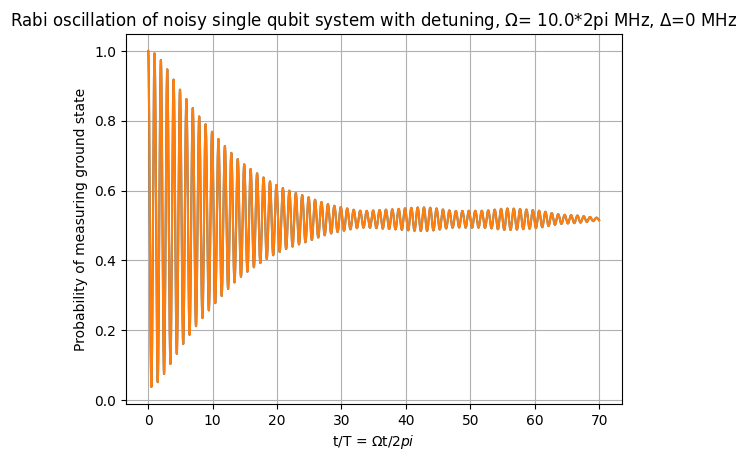

In [113]:

def plotnoisy(omega):
       #omega in units of 2pi MHz
       pgdetuned1 = pgdetuned(2*np.pi*omega, 0.01, 1000, 7, 10001, 0*2*np.pi, 4*np.pi)
       fig, ax  = plt.subplots()
       ax.plot((2*np.pi*omega)*(pgdetuned1[0] / (2*np.pi)), pgdetuned1[1])
       ax.set(xlabel='t/T = $\Omega$t/2$pi$', ylabel='Probability of measuring ground state',
              title=f'Rabi oscillation of noisy single qubit system with detuning, $\Omega$= {omega}*2pi MHz, $\Delta$=0 MHz')
       ax.grid()
       plt.plot((2*np.pi*omega)*(pgdetuned1[0] / (2*np.pi)), pgdetuned1[1])

omegavals = np.linspace(0.5, 10, 5)
for omega in omegavals:
       plotnoisy(omega)
       print(f"Omega = {omega} * 2pi MHz\nNumerical N 1/e : {extractNdetuned(omega, 0.01, 1000, 0*2*np.pi, 4*np.pi)[0]}")

C:\Users\kapil\AppData\Local\Temp\ipykernel_29448\2558986337.py:24: RuntimeWarning: divide by zero encountered in power
  pg = (1-ylevel) + ylevel*np.cos(angfreq*t)*np.exp(-((t/T1e)**C))


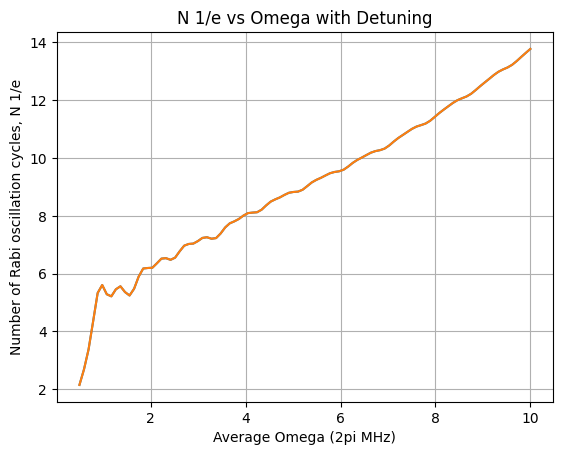

In [117]:
sweep =np.linspace(0.5, 10, 100)
nvals = []
for i in sweep:
    nvals.append(extractNdetuned(i, 0.01, 1000, 0, 2*np.pi*2)[0])

fig, ax  = plt.subplots()
ax.plot(sweep , nvals)
ax.set(xlabel='Average Omega (2pi MHz)', ylabel='Number of Rabi oscillation cycles, N 1/e',
       title='N 1/e vs Omega with Detuning')
ax.grid()
plt.plot(sweep, nvals)


From the plot it is clear that the number of Rabi oscillations up to the 1/e decay time increases as we increase Omega, in contrast to part a with no detuning. Therefore more cycles are completed before decaying, and the rate of oscillations outpaces the rate of decay for larger omega. This makes sense as analytically the effective oscillation frequency is Omega eff = sqrt(Omegam^2 + Deltam^2), which includes a non zero detuning in this case.